###  Refernece:https://github.com/unslothai/unsloth

### Installation

In [1]:
import sys
print(sys.executable)

/home/ysm/anaconda3/envs/unsloth_env/bin/python


In [2]:
# !{sys.executable} -m pip install unsloth

### Unsloth

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.53.1.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 2. Max memory: 23.51 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.6.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Alpaca.ipynb)

For text completions like novel writing, try this [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Mistral_(7B)-Text_Completion.ipynb).

In [3]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instruction = "Classify the following medical transcription into the correct medical specialty."
    inputs = examples["transcription"]
    outputs = examples["medical_specialty"]

    texts = [
        alpaca_prompt.format(instruction, input_, output_) + EOS_TOKEN
        for input_, output_ in zip(inputs, outputs)
    ]
    return {"text": texts}

In [4]:
##--------------데이터 전처리------------

In [5]:
from datasets import load_dataset, DatasetDict
import pandas as pd
from sklearn.utils import resample

# 데이터 로드
full_dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial", split="train+validation+test")
full_dataset = full_dataset.map(formatting_prompts_func, batched=True)

Repo card metadata block was not found. Setting CardData to empty.


In [6]:
# 2. 전체 데이터에 대해서 진료과별 개수 확인
full_df = pd.DataFrame(full_dataset)
specialty_counts = full_df['medical_specialty'].value_counts()
print(specialty_counts)

medical_specialty
Cardiovascular / Pulmonary    742
Orthopedic                    408
Neurology                     282
Gastroenterology              222
Obstetrics / Gynecology       182
Hematology - Oncology         120
Neurosurgery                  109
ENT - Otolaryngology           80
Nephrology                     71
Psychiatry / Psychology        68
Ophthalmology                  66
Pediatrics - Neonatal          64
Radiology                      50
Name: count, dtype: int64


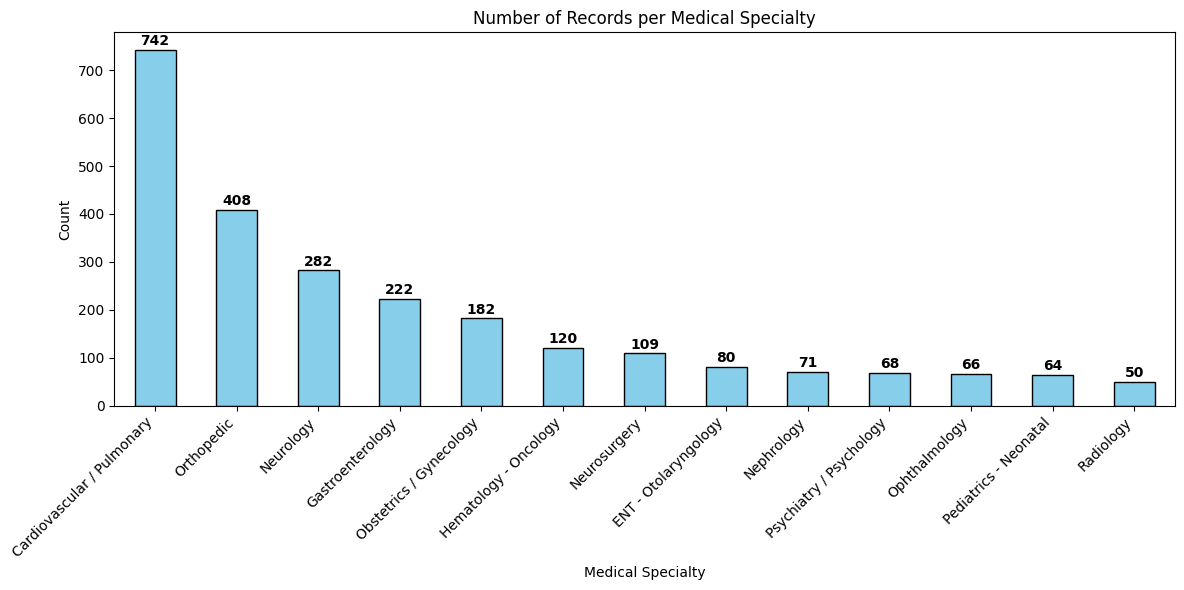

In [7]:
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
specialty_counts.plot(kind='bar', color='skyblue', edgecolor='black')

for i, count in enumerate(specialty_counts):
    plt.text(i, count + 10, str(count), ha='center', color='black', fontweight='bold')

plt.title("Number of Records per Medical Specialty")
plt.xlabel("Medical Specialty")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

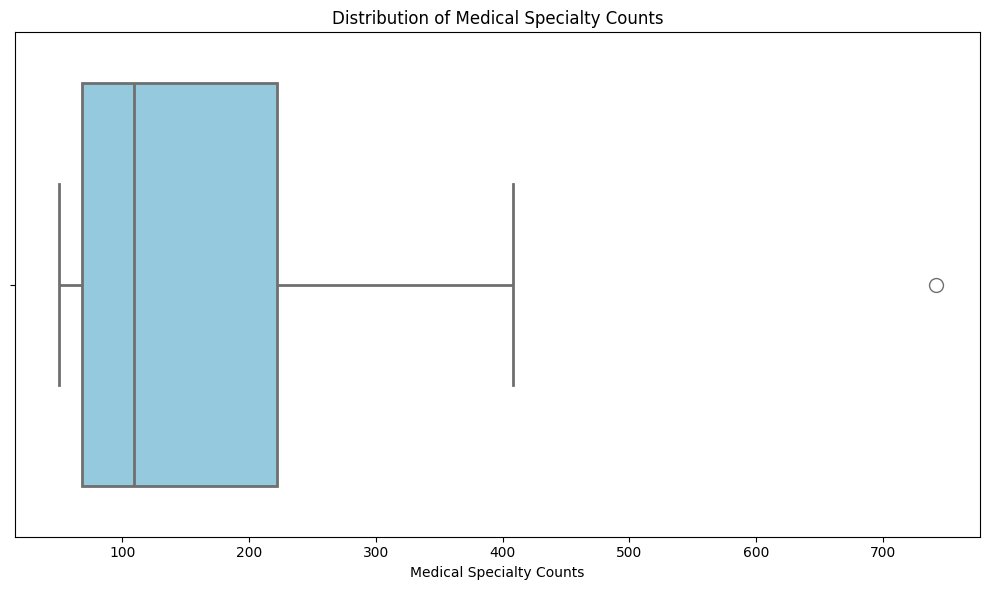

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 박스플롯 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=specialty_counts, color='skyblue', fliersize=10, linewidth=2)

# 제목, 레이블
plt.title("Distribution of Medical Specialty Counts")
plt.xlabel("Medical Specialty Counts")
plt.tight_layout()
plt.show()

In [9]:
# 3. 가장 많은 데이터를 가진 클래스 (Cardiovascular / Pulmonary) 50% 줄이기
majority_class = full_df[full_df['medical_specialty'] == 'Cardiovascular / Pulmonary']

# 샘플 수 50% 줄이기
majority_class_downsampled = resample(majority_class, 
                                      replace=False,    # 중복 없이 샘플링
                                      n_samples=int(len(majority_class) * 0.6),  # 50% 샘플
                                      random_state=42)

# 다른 클래스와 합치기
full_df_downsampled = pd.concat([full_df[full_df['medical_specialty'] != 'Cardiovascular / Pulmonary'], majority_class_downsampled])

In [10]:
# 4. 70개 미만의 데이터를 가진 데이터 삭제
specialty_counts_after_50 = full_df_downsampled['medical_specialty'].value_counts()

# 70개 미만인 클래스 삭제
full_df_cleaned = full_df_downsampled[full_df_downsampled['medical_specialty'].isin(specialty_counts_after_50[specialty_counts_after_50 >= 70].index)]

# 결과 확인
print(full_df_cleaned['medical_specialty'].value_counts())

medical_specialty
Cardiovascular / Pulmonary    445
Orthopedic                    408
Neurology                     282
Gastroenterology              222
Obstetrics / Gynecology       182
Hematology - Oncology         120
Neurosurgery                  109
ENT - Otolaryngology           80
Nephrology                     71
Name: count, dtype: int64


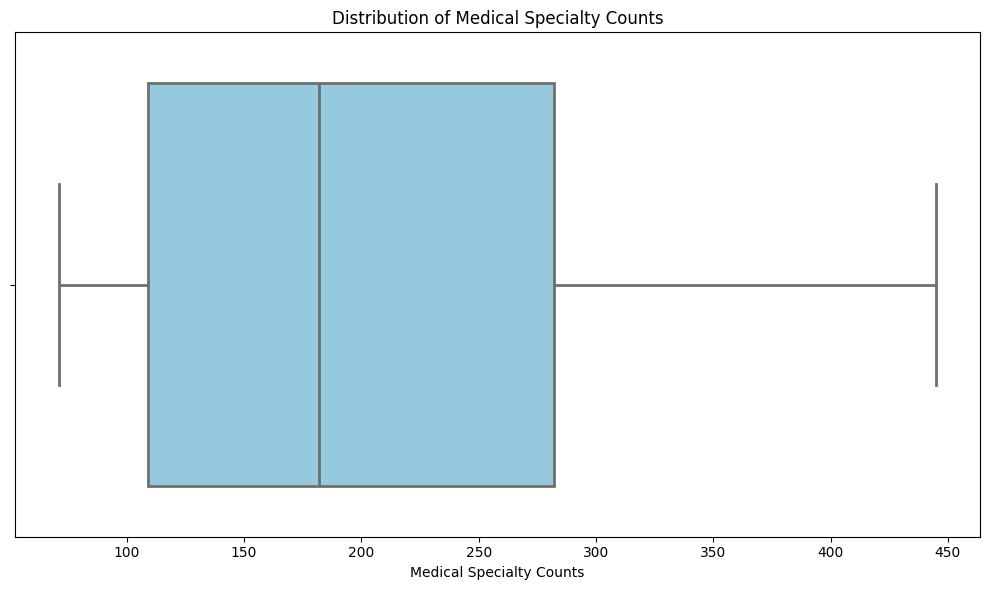

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 진료과목별 개수
specialty_counts = full_df_cleaned['medical_specialty'].value_counts()

# 박스플롯 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x=specialty_counts, color='skyblue', fliersize=10, linewidth=2)

# 제목, 레이블
plt.title("Distribution of Medical Specialty Counts")
plt.xlabel("Medical Specialty Counts")
plt.tight_layout()
plt.show()

In [12]:
# 5. train, test split (train:test = 7:3)
from datasets import Dataset, DatasetDict
from sklearn.utils import resample
import pandas as pd

# full_df_cleaned가 pandas DataFrame)datasets.Dataset 객체로 변환
dataset = Dataset.from_pandas(full_df_cleaned)

# SEED 변경하여 5번 분할 반복
seeds = [42, 123, 567, 890, 1001]  # 5개의 SEED 값

# 반복 실행하여 5번 분할 결과 저장
datasets_list = []

for seed in seeds:
    print(f"\nSEED {seed}로 분할 진행:")
    
    # 데이터 분할 (train:test = 7:3)
    train_testvalid = dataset.train_test_split(test_size=0.3, seed=seed)
    test_valid_split = train_testvalid['test'].train_test_split(test_size=0.5, seed=seed)

    # DatasetDict에 저장
    final_dataset = DatasetDict({
        'train': train_testvalid['train'],
        'validation': test_valid_split['train'],
        'test': test_valid_split['test']
    })
    
    datasets_list.append(final_dataset)  # 결과 저장

# 각 SEED별로 데이터셋 확인
for i, dataset in enumerate(datasets_list):
    print(f"\nDataset for SEED {seeds[i]}:")
    print(f"Train size: {len(dataset['train'])}, Validation size: {len(dataset['validation'])}, Test size: {len(dataset['test'])}")
    
# 데이터셋 저장
for i, dataset in enumerate(datasets_list):
    save_path = f"./split_dataset_seed_{seeds[i]}"
    dataset.save_to_disk(save_path)
    print(f"Saved dataset for SEED {seeds[i]} at: {save_path}")


SEED 42로 분할 진행:

SEED 123로 분할 진행:

SEED 567로 분할 진행:

SEED 890로 분할 진행:

SEED 1001로 분할 진행:

Dataset for SEED 42:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 123:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 567:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 890:
Train size: 1343, Validation size: 288, Test size: 288

Dataset for SEED 1001:
Train size: 1343, Validation size: 288, Test size: 288


Saving the dataset (0/1 shards):   0%|          | 0/1343 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saved dataset for SEED 42 at: ./split_dataset_seed_42


Saving the dataset (0/1 shards):   0%|          | 0/1343 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saved dataset for SEED 123 at: ./split_dataset_seed_123


Saving the dataset (0/1 shards):   0%|          | 0/1343 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saved dataset for SEED 567 at: ./split_dataset_seed_567


Saving the dataset (0/1 shards):   0%|          | 0/1343 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saved dataset for SEED 890 at: ./split_dataset_seed_890


Saving the dataset (0/1 shards):   0%|          | 0/1343 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/288 [00:00<?, ? examples/s]

Saved dataset for SEED 1001 at: ./split_dataset_seed_1001


In [7]:
### ------------- 여기서부터 돌리기 ------------------
### seed num: 42, 123, 567, 890, 1001

from datasets import load_from_disk

# 첫 번째 SEED의 데이터를 불러오기
first_seed_dataset = load_from_disk("./split_dataset_seed_123")

# 각 split에 접근
train_dataset = first_seed_dataset['train']
eval_dataset = first_seed_dataset['validation']
test_dataset = first_seed_dataset['test']

# 확인
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(eval_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1343
Validation size: 288
Test size: 288


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [8]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc,
        
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1343 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/288 [00:00<?, ? examples/s]

In [9]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.51 GB.
7.625 GB of memory reserved.


In [10]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,343 | Num Epochs = 3 | Total steps = 60
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 4 x 1) = 64
 "-____-"     Trainable parameters = 41,943,040 of 8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.071700
2,2.029400
3,2.095500
4,1.997700
5,1.976300
6,1.903200
7,1.864200
8,1.810600
9,1.775100
10,1.736700


# Test Evaluation

100%|█████████████████████████████████████████| 288/288 [00:57<00:00,  5.00it/s]


✅ Accuracy: 0.7743055555555556

📄 Classification Report:
                          precision    recall  f1-score   support

cardiovascular/pulmonary       0.77      0.86      0.81        58
      ent/otolaryngology       1.00      0.82      0.90        11
        gastroenterology       0.90      0.79      0.84        34
     hematology/oncology       0.54      0.37      0.44        19
              nephrology       0.67      0.60      0.63        10
               neurology       0.73      0.80      0.77        45
            neurosurgery       0.33      0.27      0.30        15
   obstetrics/gynecology       0.81      0.96      0.88        26
              orthopedic       0.89      0.84      0.87        70

               micro avg       0.79      0.77      0.78       288
               macro avg       0.74      0.70      0.71       288
            weighted avg       0.78      0.77      0.77       288



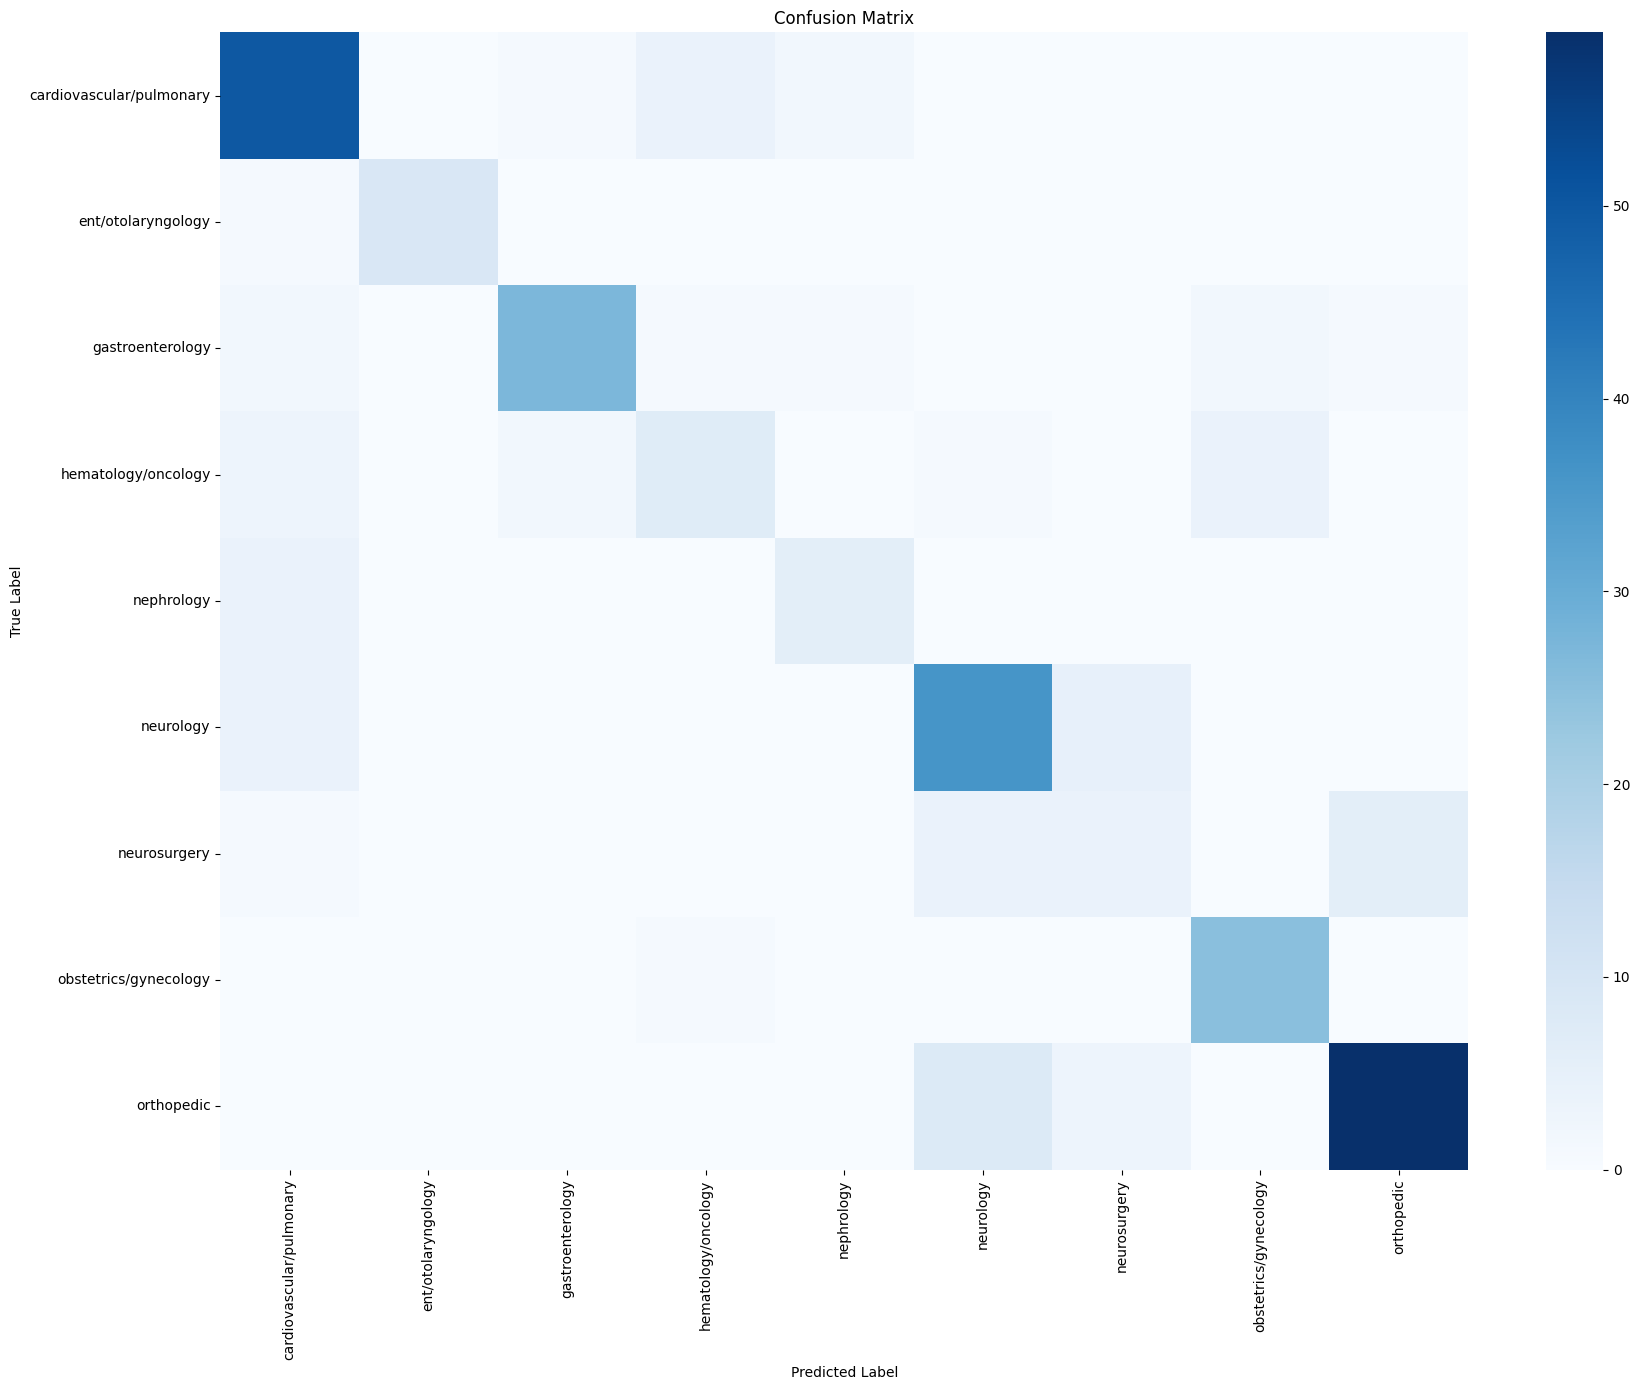


--- examples ---

Example 1:
Transcription:
PREOPERATIVE DIAGNOSIS: , Abdominal aortic aneurysm.,POSTOPERATIVE DIAGNOSIS: , Abdominal aortic aneurysm.,OPERATION PERFORMED:,  Endovascular abdominal aortic aneurysm repair.,FINDINGS: , The patient was brought to the OR with the known 4 cm abdominal aortic aneurysm + 2.5 cm right common iliac artery aneurysm.  A Gore exclusive device was used 3 pieces were used to effect the repair.  We had to place an iliac extender down in to right external iliac artery to manage the right common iliac artery aneurysm.  The right hypogastric artery had been previously coiled off.  Left common femoral artery was used for the _____ side.  We had small type 2 leak right underneath the take off the renal arteries, this was not felt to be type I leak and this was very delayed filling and it was felt that this was highly indicative of type 2 leak from a lumbar artery, which commonly come off in this area.  It was felt that this would seal after reversal of th

In [11]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

# example
examples_to_show = 3  
example_results = []

# Alpaca prompt 템플릿
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction = "Classify the following medical transcription into the correct medical specialty."

# 라벨 전처리 함수
def normalize_label(label):
    return label.lower().replace("-", "/").replace(" / ", "/").strip()

# 입력 길이 제한용 토큰 수
MAX_INPUT_TOKENS = 4096

labels, preds = [], []

# 라벨 집합 확보 (정규화된 기준으로)
all_classes = sorted(list({normalize_label(x["medical_specialty"]) for x in test_dataset}))

for example in tqdm(test_dataset):
    transcription = example["transcription"]
    true_label = normalize_label(example["medical_specialty"])
    labels.append(true_label)

    prompt = alpaca_prompt.format(instruction, transcription, "")

    # 토크나이징 + 길이 제한
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=32, use_cache=True)
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # "### Response:" 이후 예측값만 추출
    response = output_text.split("### Response:")[-1].strip().split("\n")[0]
    pred = normalize_label(response)
    preds.append(pred)

    # 평가 결과 예시 저장
    if len(example_results) < examples_to_show:
        example_results.append({
            "transcription": transcription,
            "true_label": true_label,
            "predicted_label": pred,
            "model_response": response,
        })

# 정확도 및 리포트 출력
print("✅ Accuracy:", accuracy_score(labels, preds))
print("\n📄 Classification Report:")
print(classification_report(labels, preds, labels=all_classes))

# Confusion matrix
cm = confusion_matrix(labels, preds, labels=all_classes)

plt.figure(figsize=(18, 14))
sns.heatmap(cm, xticklabels=all_classes, yticklabels=all_classes, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 예시 결과 3개 출력
print("\n--- examples ---")
for i, r in enumerate(example_results, 1):
    print(f"\nExample {i}:")
    print(f"Transcription:\n{r['transcription']}")
    print(f"True Label: {r['true_label']}")
    print(f"Predicted Label: {r['predicted_label']}")
    print(f"Model Response: {r['model_response']}")

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [12]:
model.save_pretrained("lora_model_7_3_seed2")  # Local saving
tokenizer.save_pretrained("lora_model_7_3_seed2")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model_7_3_seed2/tokenizer_config.json',
 'lora_model_7_3_seed2/special_tokens_map.json',
 'lora_model_7_3_seed2/chat_template.jinja',
 'lora_model_7_3_seed2/tokenizer.json')

# zero-shot

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.53.1.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 2. Max memory: 23.51 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [2]:
### seed num: 42, 123, 567, 890, 1001

from datasets import load_from_disk

# SEED의 데이터를 불러오기
first_seed_dataset = load_from_disk("./split_dataset_seed_123")

# 각 split에 접근
train_dataset = first_seed_dataset['train']
eval_dataset = first_seed_dataset['validation']
test_dataset = first_seed_dataset['test']

# 확인
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(eval_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1343
Validation size: 288
Test size: 288


100%|█████████████████████████████████████████| 288/288 [02:59<00:00,  1.60it/s]

✅ Accuracy: 0.6701388888888888

📄 Classification Report:
                          precision    recall  f1-score   support

cardiovascular/pulmonary       0.88      0.64      0.74        58
      ent/otolaryngology       0.56      0.82      0.67        11
        gastroenterology       0.78      0.82      0.80        34
     hematology/oncology       0.67      0.11      0.18        19
              nephrology       0.53      0.90      0.67        10
               neurology       0.67      0.71      0.69        45
            neurosurgery       0.36      0.80      0.50        15
   obstetrics/gynecology       0.92      0.88      0.90        26
              orthopedic       1.00      0.59      0.74        70

               micro avg       0.74      0.67      0.70       288
               macro avg       0.71      0.70      0.65       288
            weighted avg       0.80      0.67      0.70       288



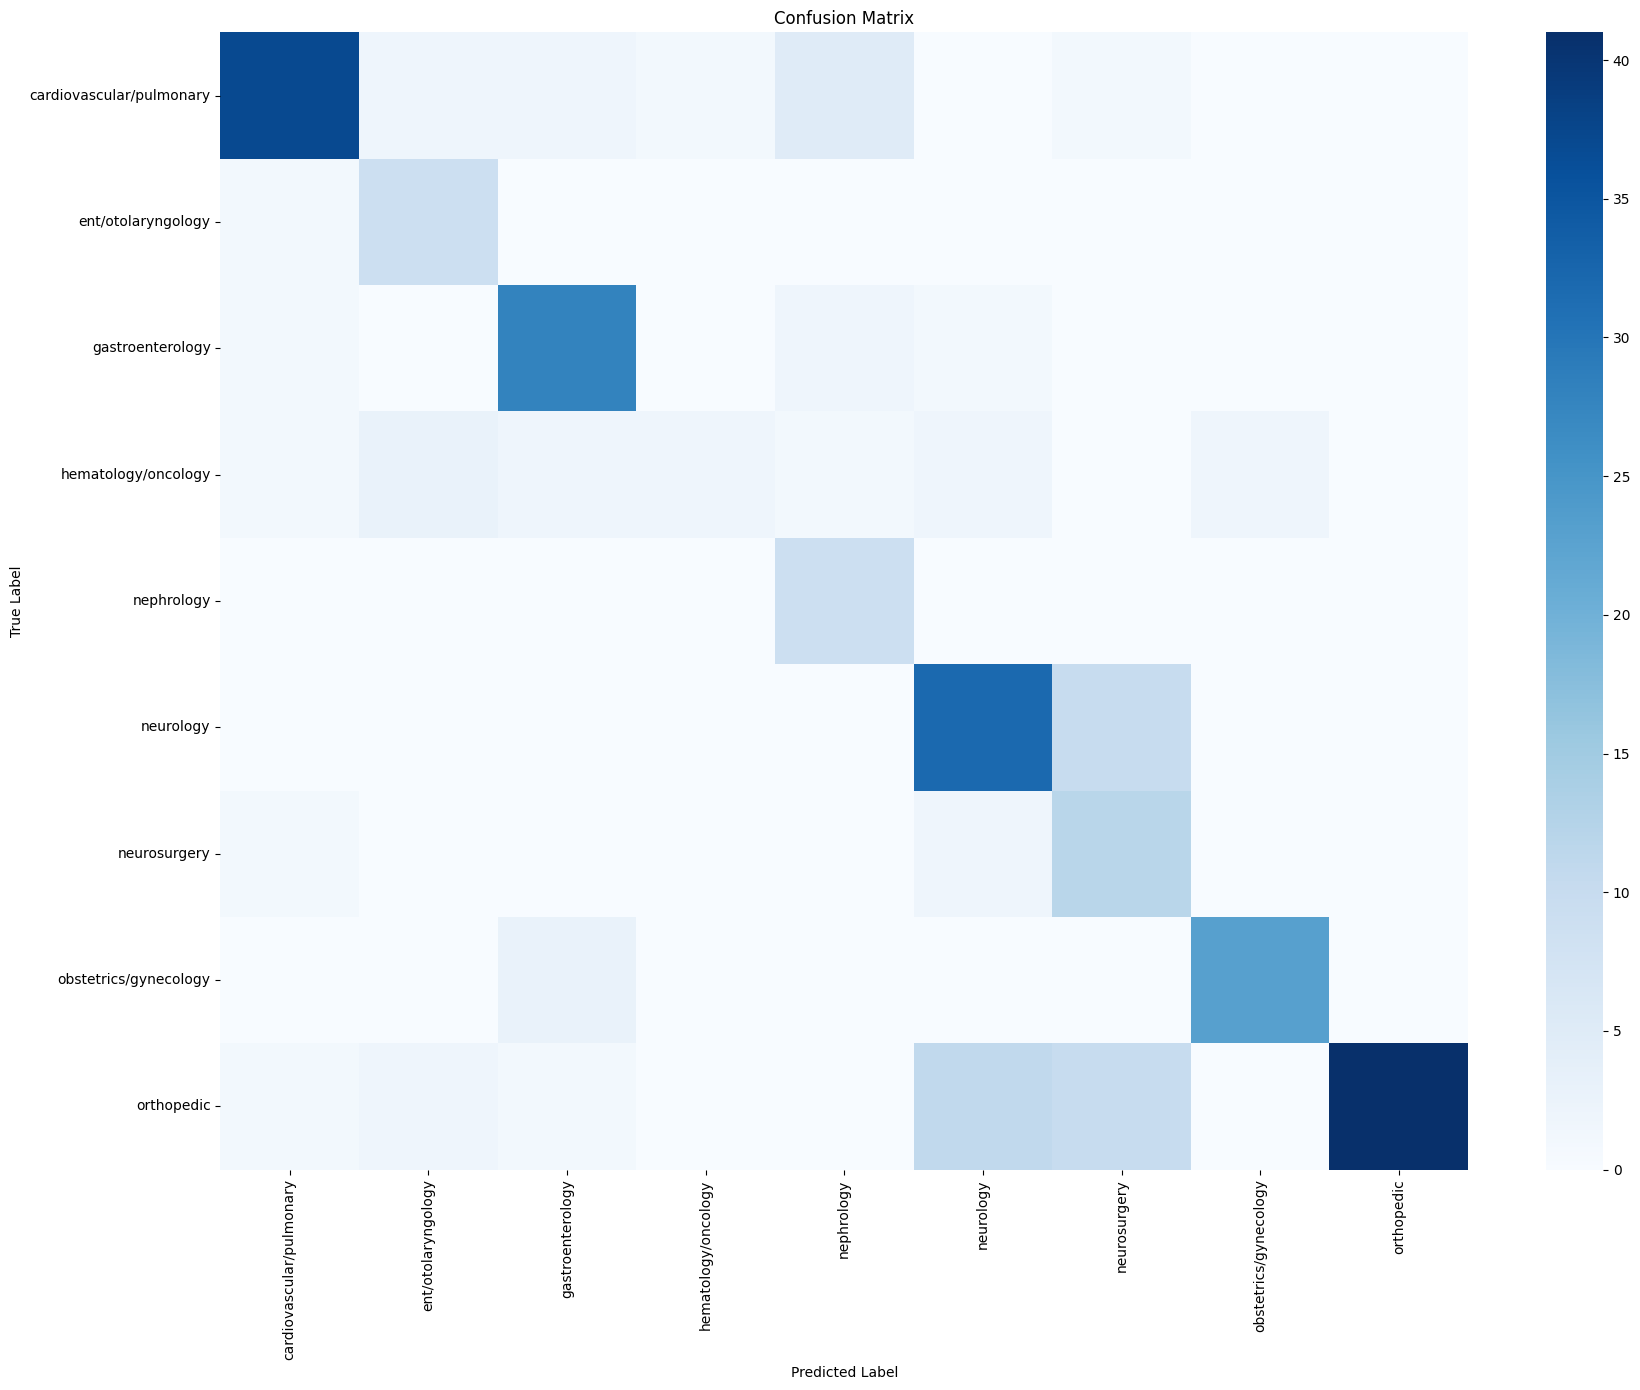


--- examples ---

Example 1:
Transcription:
PREOPERATIVE DIAGNOSIS: , Abdominal aortic aneurysm.,POSTOPERATIVE DIAGNOSIS: , Abdominal aortic aneurysm.,OPERATION PERFORMED:,  Endovascular abdominal aortic aneurysm repair.,FINDINGS: , The patient was brought to the OR with the known 4 cm abdominal aortic aneurysm + 2.5 cm right common iliac artery aneurysm.  A Gore exclusive device was used 3 pieces were used to effect the repair.  We had to place an iliac extender down in to right external iliac artery to manage the right common iliac artery aneurysm.  The right hypogastric artery had been previously coiled off.  Left common femoral artery was used for the _____ side.  We had small type 2 leak right underneath the take off the renal arteries, this was not felt to be type I leak and this was very delayed filling and it was felt that this was highly indicative of type 2 leak from a lumbar artery, which commonly come off in this area.  It was felt that this would seal after reversal of th

In [3]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

# example
examples_to_show = 3  
example_results = []

# Alpaca prompt 템플릿
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction = """Classify the medical document into **one** of the following medical specialties based on its content. Choose **only one** label from the list:

- Cardiovascular / Pulmonary
- Orthopedic
- Neurology
- Gastroenterology
- Obstetrics / Gynecology
- Hematology - Oncology
- Neurosurgery
- ENT - Otolaryngology
- Nephrology
- Psychiatry / Psychology
- Ophthalmology
- Pediatrics - Neonatal
- Radiology

Respond with only the exact name of the chosen medical specialty from the list above.

---
Example:

Input: 
PREOPERATIVE DIAGNOSIS: , Hemarthrosis, left knee, status post total knee replacement, rule out infection.,POSTOPERATIVE DIAGNOSIS: , Hemarthrosis, left knee, status post total knee replacement, rule out infection.,OPERATIONS:,1.  Arthrotomy, left total knee.,2.  Irrigation and debridement, left knee.,3.  Polyethylene exchange, left knee.,COMPLICATION: , None.,TOURNIQUET TIME:  ,58 minutes.,ESTIMATED BLOOD LOSS: , Minimal.,ANESTHESIA:  ,General.,INDICATIONS:  ,This patient underwent an uncomplicated left total knee replacement.  Postoperatively, unfortunately did not follow up with PT/INR blood test and he was taking Coumadin.  His INR was seemed to elevated and developed hemarthrosis.  Initially, it did look very benign, although over the last 24 hours it did become irritable and inflamed, and he therefore was indicated with the above-noted procedure.,This procedure as well as alternatives was discussed in length with the patient and he understood them well.  Risks and benefits were also discussed.  Risks such as bleeding, infection, damage to blood vessels, damage to nerve roots, need for further surgeries, chronic pain with range of motion, risk of continued discomfort, risk of need for further reconstructive procedures, risk of need for total knee revision, risk of blood clots, pulmonary embolism, myocardial infarction, and risk of death were discussed.  He understood them well.  All questions were answered and he signed consent for the procedure as described.,DESCRIPTION OF PROCEDURE: , The patient was placed on operating table and general anesthesia was achieved.  The left lower extremity was then prepped and draped in the usual sterile manner.  The leg was elevated and the tourniquet was inflated to 325 mmHg.  A longitudinal incision was then made and carried down through subcutaneous tissues.  This was made through the prior incision site.  There were some fatty necrotic tissues through the incision region and all necrotic tissue was debrided sharply on both sides of the incision site.  Medial and lateral flaps were then made.  The prior suture was identified, the suture removed and then a medial parapatellar arthrotomy was then performed.  Effusion within the knee was noted.  All hematoma was evacuated.  I then did flex the knee and removed the polyethylene.  Once the polyethylene was removed I did irrigate the knee with total of 9 liters of antibiotic solution.  Further debridement was performed of all inflamed tissue and thickened synovial tissue.  A 6 x 16-mm Stryker polyethylene was then snapped back in position.  The knee has excellent stability in all planes and I did perform a light manipulation to improve the flexion of the knee.  Further irrigation was performed on the all soft tissue in the knee with additional 3 liters of normal saline.  The knee was placed in a flexed position and the extensor mechanism was reapproximated using #2 Ethibond suture in a figure-of-eight manner.  The subcutaneous tissue was reapproximated in layers using #1 and 2-0 Vicryl sutures, and the skin was reapproximated using staples.  Prior to closure a Hemovac drain was inserted through a superolateral approach into the knee joint.,No complications were encountered throughout the procedure, and the patient tolerated the procedure well.  The patient was taken to recovery room in stable condition.

Response:
orthopedic
---

"""

# 라벨 전처리 함수
def normalize_label(label):
    return label.lower().replace("-", "/").replace(" / ", "/").strip()

# 입력 길이 제한용 토큰 수
MAX_INPUT_TOKENS = 4096

labels, preds = [], []

# 라벨 집합 확보 (정규화된 기준으로)
all_classes = sorted(list({normalize_label(x["medical_specialty"]) for x in test_dataset}))

for example in tqdm(test_dataset):
    transcription = example["transcription"]
    true_label = normalize_label(example["medical_specialty"])
    labels.append(true_label)

    prompt = alpaca_prompt.format(instruction, transcription, "")

    # 토크나이징 + 길이 제한
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_TOKENS).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=32, use_cache=True)
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # "### Response:" 이후 예측값만 추출
    response = output_text.split("### Response:")[-1].strip().split("\n")[0]
    pred = normalize_label(response)
    preds.append(pred)

    # 평가 결과 예시 저장
    if len(example_results) < examples_to_show:
        example_results.append({
            "transcription": transcription,
            "true_label": true_label,
            "predicted_label": pred,
            "model_response": response,
        })

# 정확도 및 리포트 출력
print("✅ Accuracy:", accuracy_score(labels, preds))
print("\n📄 Classification Report:")
print(classification_report(labels, preds, labels=all_classes))

# Confusion matrix
cm = confusion_matrix(labels, preds, labels=all_classes)

plt.figure(figsize=(18, 14))
sns.heatmap(cm, xticklabels=all_classes, yticklabels=all_classes, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 예시 결과 3개 출력
print("\n--- examples ---")
for i, r in enumerate(example_results, 1):
    print(f"\nExample {i}:")
    print(f"Transcription:\n{r['transcription']}")
    print(f"True Label: {r['true_label']}")
    print(f"Predicted Label: {r['predicted_label']}")
    print(f"Model Response: {r['model_response']}")